## Analysis
The analysis includes:
- Testing hypothesis that diversity can increase performance;
- That increase is conditional on performance difference between individuals;
- That diversity correlates with higher jumps and more exploration of dense neighborhoods, in general;
- That this is what induces performance gains.

Imports and initialization

In [368]:
import glob
from animal_game.agents import Agent
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool

Define parameters, find logfiles.

In [369]:
date = '21_08_20'
models_path = 'animal_game/models'
log_path = 'animal_game/logs'
analyses_path = 'animal_game/analyses'

In [370]:
fs = glob.glob(f'{log_path}/{date}/individual/*')
pair_fs = glob.glob(f'{log_path}/{date}/pairs/*')

Define functions for aggregation of individual logfiles

In [4]:
_jumps = lambda x: np.nanmean(abs(x - x.shift(1)))

In [5]:
individual_metric_dict = {'turn': 'max',
                          'threshold': 'first',
                          'agent': 'first',
                          'init_seed': 'first',
                          'prob0': ['mean', _jumps],
                          'ndens0': 'mean',
                          'ndens_current0': 'mean',
                          'response': 'last'}
pair_metric_dict = {'turn':'max', 
                    'log_id': 'first',
                    'agent_0': 'first',
                    'agent_1': 'first',
                    'threshold':'first',
                    'init_seed': 'first',
                    'prob0': ['mean', _jumps], 
                    'prob1': ['mean', _jumps],
                    'jump_speaker': 'mean',
                    'jump_listener': 'mean',
                    'jump_difference': ['mean', lambda x: np.mean(abs(x))],
                    'ndens0': 'mean',
                    'ndens1': 'mean',
                    'ndens_current0': 'mean',
                    'ndens_current1':'mean',
                    'response': 'last'}

In [6]:
individual_metric_names = ['iter', 'performance', 'threshold', 
                           'agent_name', 'init_seed', 
                           'mean_jump', 'mean_jump_differential',
                           'mean_neighborhood_density',
                           'mean_neighborhood_density_current',
                           'last_response']
pair_metric_names = ['iter', 'performance', 'pair',
                     'agent_0', 'agent_1',
                     'threshold', 'init_seed',
                     'mean_jump_0', 'mean_jump_differential_0',
                     'mean_jump_1', 'mean_jump_differential_1',
                     'mean_jump_speaker', 'mean_jump_listener',
                     'mean_jump_difference', 'mean_jump_difference_absolute',
                     'mean_neighborhood_density_0', 
                     'mean_neighborhood_density_1',
                     'mean_neighborhood_density_current_0', 
                     'mean_neighborhood_density_current_1', 
                     'last_response']

#### Get individual metrics

In [8]:
def _compute_individual_aggs(f):
    log = pd.read_csv(f)
    ind_agg = log.groupby('iter').agg(individual_metric_dict).reset_index()
    ind_agg.columns = individual_metric_names
    ind_agg['noise_level'] = ind_agg['agent_name'].str.split('_').str[1].astype(float)
    return ind_agg

In [9]:
pool = Pool(20)
results = pool.map(_compute_individual_aggs, fs)
pool.close()

In [10]:
for idx, ind_agg in enumerate(results):
    if idx == 0:
        ind_aggs = ind_agg.copy()
    else:
        ind_aggs = pd.concat([ind_aggs, ind_agg], 
                              ignore_index=True)

In [17]:
ind_aggs.to_csv(f'{analyses_path}/{date}/individual.tsv', sep='\t', index=False)

#### Get pair metrics

In [18]:
def _compute_pair_aggs(f):
    log = pd.read_csv(f)
    log['agent_0'] = log['log_id'].str.split('_').str[:3].str.join('_').iloc[0]
    log['agent_1'] = log['log_id'].str.split('_').str[3:].str.join('_').iloc[0]
    log['agent_speaking'] = np.where(log['agent']==log['agent_0'], 
                                     'agent_0', 
                                     'agent_1')
    log['jump_speaker'] = np.where(log['agent_speaking']=='agent_0', 
                                   log['prob0'], 
                                   log['prob1'])
    log['jump_listener'] = np.where(log['agent_speaking']=='agent_0', 
                                    log['prob1'], 
                                    log['prob0'])
    log['jump_difference'] = log['jump_listener'] - log['jump_speaker']
    pair_agg = log.groupby('iter').agg(pair_metric_dict).reset_index()
    pair_agg.columns = pair_metric_names
    pair_agg['noise_level'] = pair_agg['agent_0'].str.split('_').str[1].astype(float)
    return pair_agg

In [19]:
pool = Pool(20)
results = pool.map(_compute_pair_aggs, pair_fs)
pool.close()

In [20]:
for idx, pair_agg in enumerate(results):
    if idx == 0:
        pair_aggs = pair_agg
    else:
        pair_aggs = pd.concat([pair_aggs, 
                               pair_agg], ignore_index=True)

In [21]:
pair_aggs.to_csv(f'{analyses_path}/{date}/pair.tsv', sep='\t', index=False)

## Merge performance

In [37]:
ind_aggs = pd.read_csv(f'{analyses_path}/{date}/individual.tsv', sep='\t')
pair_aggs = pd.read_csv(f'{analyses_path}/{date}/pair.tsv', sep='\t')
ind_aggs.drop(['iter', 'threshold'], axis=1, inplace=True)
pair_aggs.drop(['iter', 'threshold'], axis=1, inplace=True)

In [38]:
rename_agent_0 = {'performance_x': 'performance_pair',
                  'performance_y': 'performance_a0',
                  'mean_neighborhood_density': 'neighborhood_density_a0',
                  'mean_neighborhood_density_current': 'neighborhood_density_current_a0_individual',
                  'noise_level_y': 'noise_level_a0',
                  'mean_jump': 'mean_jump_a0',
                  'mean_jump_differential': 'mean_jump_differential_a0_individual',
                  'last_response_x': 'last_response_pair',
                  'last_response_y': 'last_response_a0'}
rename_agent_1 = {'performance': 'performance_a1',
                  'mean_neighborhood_density': 'neighborhood_density_a1_individual',
                  'mean_neighborhood_density_current': 'neighborhood_density_current_a1_individual',
                  'mean_jump': 'mean_jump_a1',
                  'mean_jump_differential': 'mean_jump_differential_a1_individual',
                  'last_response': 'last_response_a1',
                  'noise_level': 'noise_level_a1'}

In [39]:
def _merge_individual(pdf, idf, agent_nr):
    pdf = pdf.merge(idf, 
                    right_on=['agent_name', 'init_seed'],
                    left_on=[f'agent_{agent_nr}', 'init_seed']).drop(['agent_name'], axis=1)
    if agent_nr == '0':
        pdf.drop('noise_level_x', axis=1, inplace=True)
        pdf = pdf.rename(rename_agent_0, axis=1)
    else:
        pdf.drop('noise_level', axis=1, inplace=True)
        pdf = pdf.rename(rename_agent_1, axis=1)
    return pdf

In [40]:
pair_aggs = _merge_individual(pair_aggs, ind_aggs, '0')
pair_aggs = _merge_individual(pair_aggs, ind_aggs, '1')

In [41]:
pair_aggs['performance_best'] = np.where(pair_aggs['performance_a1'] > pair_aggs['performance_a0'], 
                                         pair_aggs['performance_a1'],
                                         pair_aggs['performance_a0'])
pair_aggs['performance_difference_individuals'] = abs(pair_aggs['performance_a1'] - pair_aggs['performance_a0'])
pair_aggs['is_gain'] = (pair_aggs['performance_pair'] > pair_aggs['performance_best']).astype(int)
pair_aggs['amount_gain'] = pair_aggs['performance_pair'] - pair_aggs['performance_best']

Get diversity metadata

In [42]:
pair_meta = pd.read_csv(f'{models_path}/{date}/sampled_pairs.tsv', 
                        sep='\t', index_col=0)[['distance', 'fname_1', 'fname_2']]
pair_meta['pair'] = pair_meta['fname_1'].str.strip('.tsv') + '_' + pair_meta['fname_2'].str.strip('.tsv')
pair_meta = pair_meta[['distance', 'pair']]
pair_meta = pair_meta.rename({'distance': 'diversity'}, axis=1)
pair_aggs = pair_aggs.merge(pair_meta, on='pair')

In [43]:
pair_aggs.to_csv(f'{analyses_path}/{date}/processed_complete.tsv', sep='\t', index=False)

### Effect of diversity on gain

In [ ]:
pair_aggs['pos_gain'] = np.where(pair_aggs['amount_gain']>0, pair_aggs['amount_gain'], 0)
pair_aggs['mean_jump_best_individual'] = np.where(pair_aggs['performance_best'] == pair_aggs['performance_a0'],
                                                  pair_aggs['mean_jump_a0'], pair_aggs['mean_jump_a1'])
pair_aggs['mean_jump_best_pair'] = np.where(pair_aggs['performance_best'] == pair_aggs['performance_a0'],
                                                  pair_aggs['mean_jump_0'], pair_aggs['mean_jump_1'])
pair_aggs['pair_ind_jump_difference'] = pair_aggs['mean_jump_speaker'] - pair_aggs['mean_jump_best_individual']
pair_aggs['pair_ind_ndens_difference'] = - pair_aggs['neighborhood_density_a0'] + pair_aggs['mean_neighborhood_density_0']

In [217]:
ag = pair_aggs.groupby('pair').agg({'pos_gain': 'mean', 
                                    'is_gain': ['mean', lambda x: np.std(x)],
                                    'amount_gain': ['mean', lambda x: np.std(x)],
                                    'diversity':'first', 
                                    'noise_level_a0': 'mean',
                                    'performance_difference_individuals': 'mean',
                                    'performance_best': 'mean',
                                    'performance_pair': ['mean', 'std'],
                                    'mean_jump_difference_absolute': 'mean',
                                    'mean_jump_speaker': 'mean',
                                    'mean_jump_listener': 'mean',
                                    'jumpdiff': 'mean'}).reset_index()
names = ['pair', 'pos_gain', 'is_gain_mean', 'is_gain_std',
         'amount_gain_mean', 'amount_gain_std',
         'diversity', 'noise_level_a0',
         'performance_difference_individuals', 
         'performance_best', 'performance_pair_mean', 'performance_pair_std',
         'mean_jump_difference_absolute',
         'mean_jump_speaker', 'mean_jump_listener',
         'jumpdiff']
ag.columns = names

### Performance by diversity

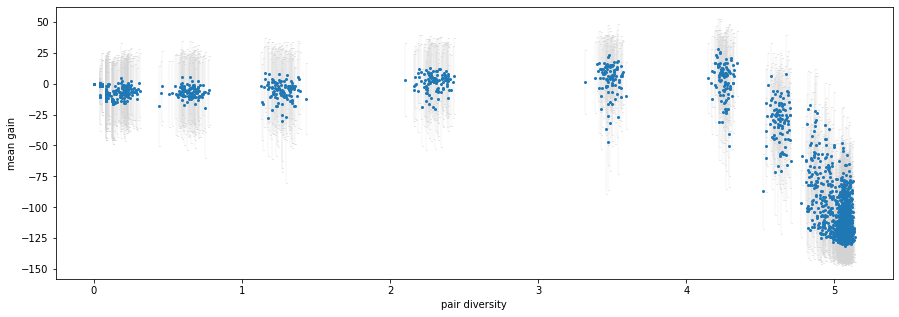

In [203]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(data=ag,
             x='diversity', 
             y='amount_gain_mean',
             yerr='amount_gain_std',
             fmt='o',
             ecolor='lightgray',
             ms=2,
             capsize=.5, 
             elinewidth=.2)
plt.xlabel('pair diversity')
plt.ylabel('mean gain')
plt.show()

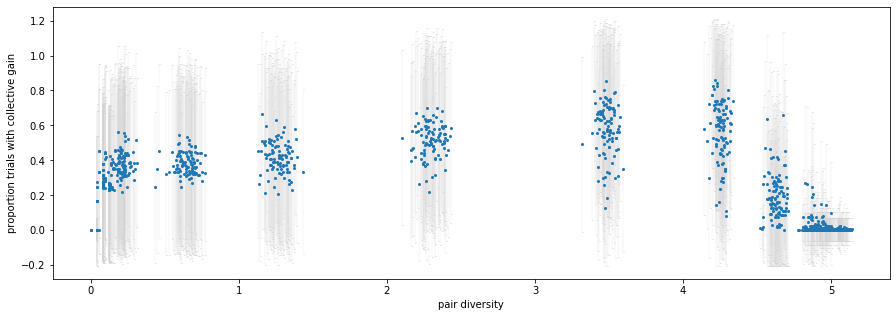

In [200]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(data=ag,
             x='diversity', 
             y='is_gain_mean',
             yerr='is_gain_std',
             fmt='o',
             ecolor='lightgray',
             ms=2,
             capsize=.5, 
             elinewidth=.2)
plt.xlabel('pair diversity')
plt.ylabel('proportion trials with collective gain')
plt.show()

### Trial-by-trial performance, by noise level

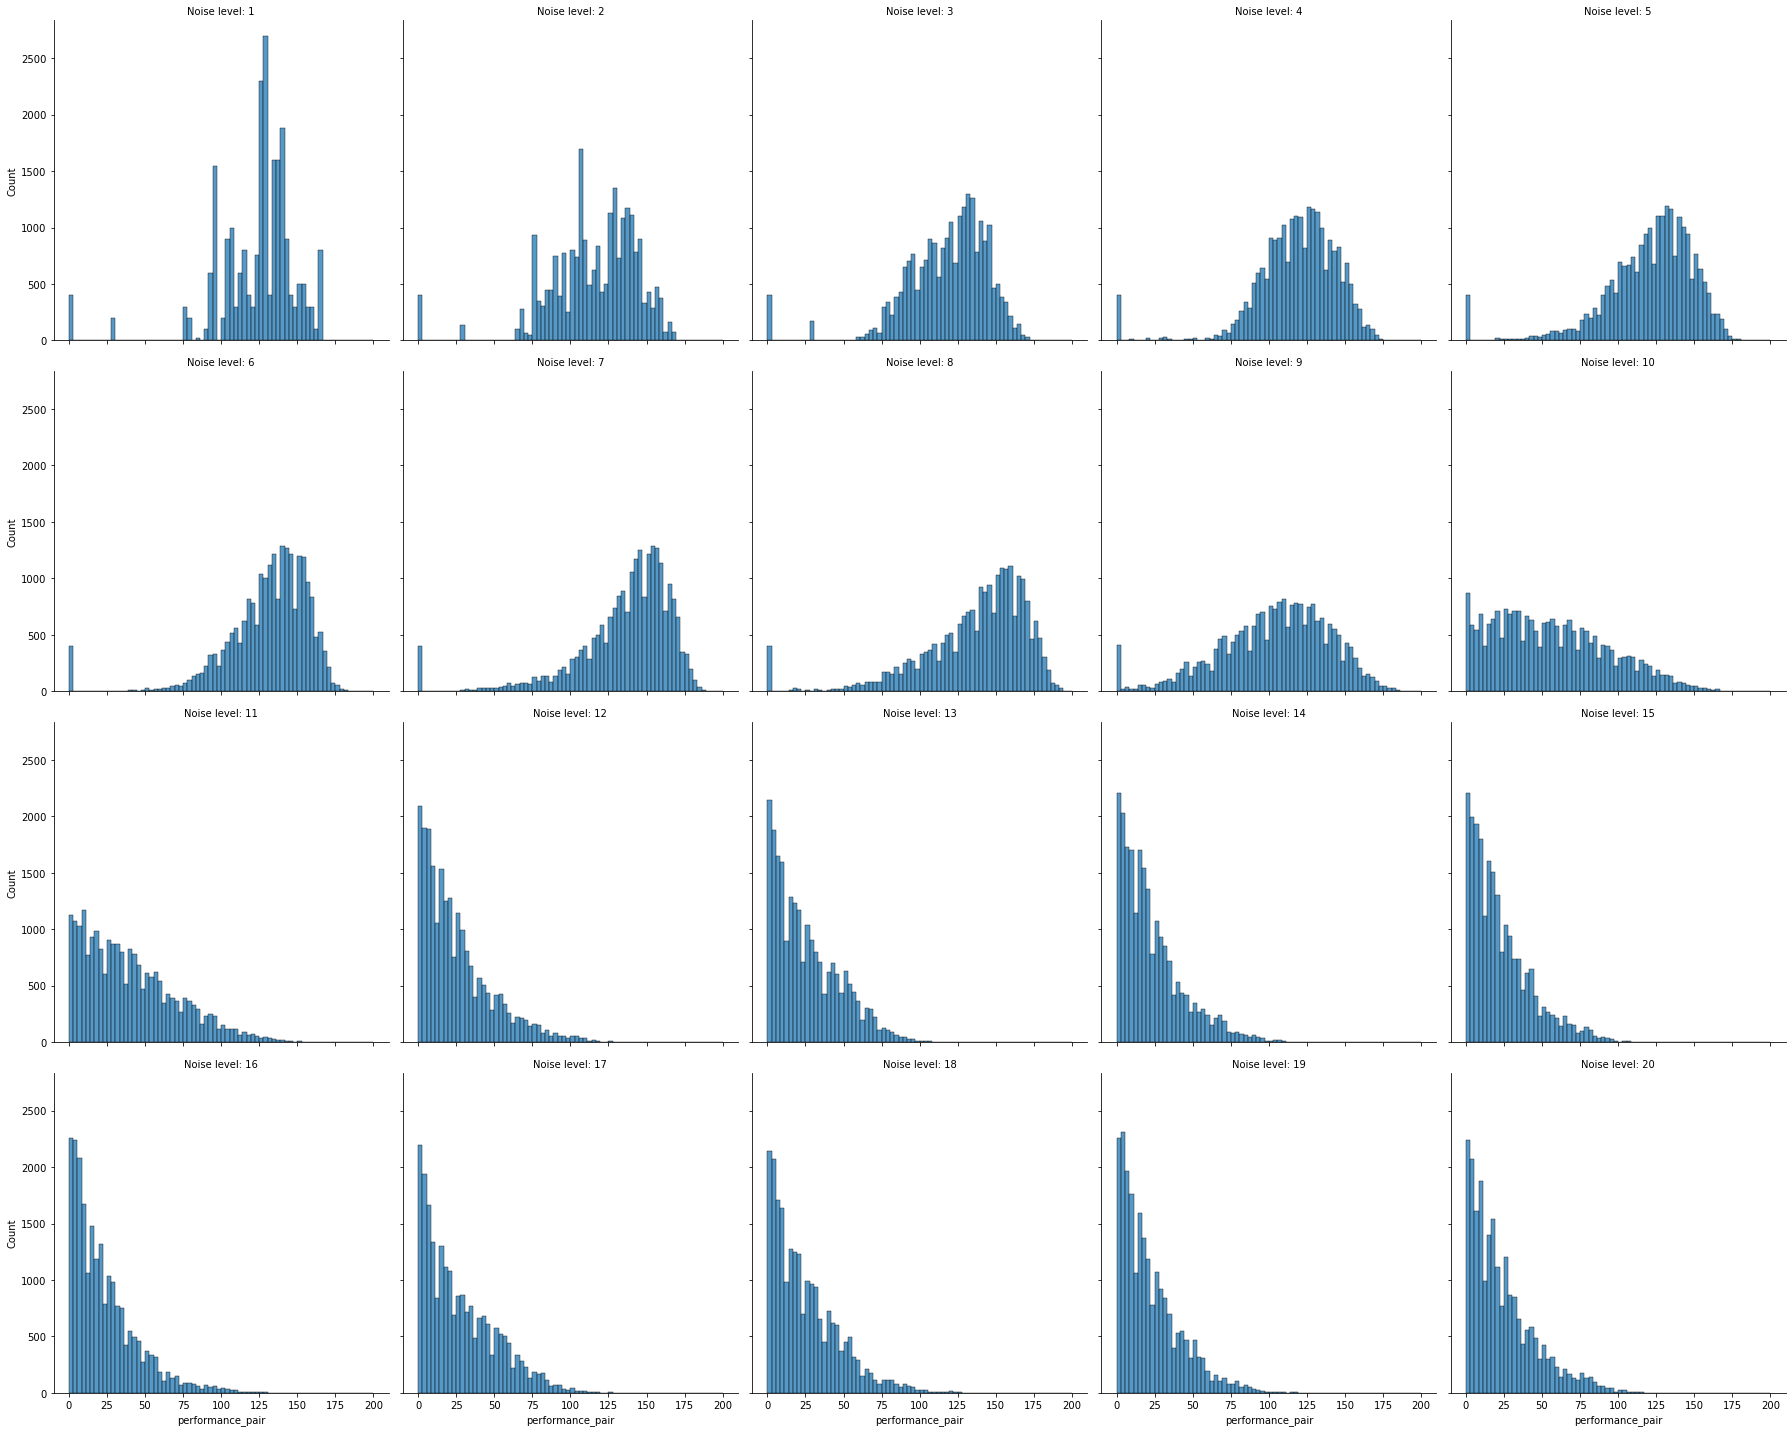

In [481]:
pair_aggs['noise_level_recoded'] = (pair_aggs['noise_level_a0'] + 1).astype(int)
f = sns.displot(data=pair_aggs, 
                x='performance_pair', col='noise_level_recoded',  
                col_wrap=5)
f.set_titles("Noise level: {col_name}")

### Aggregate performance, by noise level

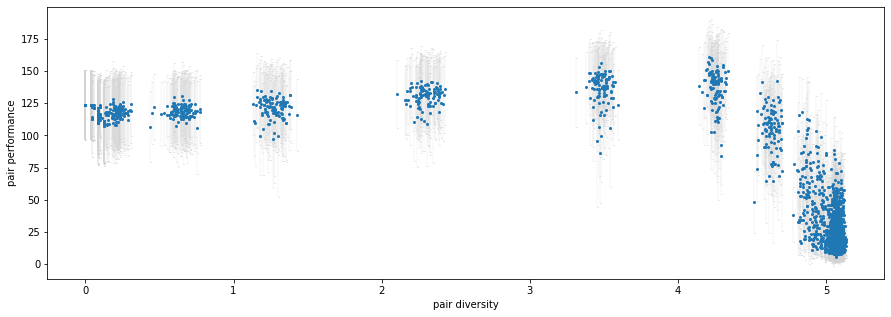

In [482]:
fig, ax = plt.subplots(figsize=(15,5))
plt.errorbar(data=ag,
             x='diversity', 
             y='performance_pair_mean',
             yerr='performance_pair_std',
             fmt='o',
             ecolor='lightgray',
             ms=2,
             capsize=.5, 
             elinewidth=.2)
plt.xlabel('pair diversity')
plt.ylabel('pair performance')
plt.show()

Reminder of variables we do have:
- **performance_pair**: actual performance;
- **pair**: pair id;
- **agent_0, agent_1**: agent ids;
- **init_seed**: starting word;
- **mean_jump_0**: mean jump of agent 0 in the pair condition;
- **mean_jump_differential_0**: metric of alternation between high and low jumps for agent 0 in pair condition;
- **mean_jump_speaker**: mean jump for speaker in pair condition;
- **mean_jump_listener**: mean jump for the listener in pair condition;
- **mean_jump_difference**: mean of jump for the listener - jump for the speaker;
- **mean_jump_difference_absolute**: same as above but absolute;
- **mean_neighborhood_density_0**: mean neighborhood density for named animal in agent 0's space;
- **mean_neighborhood_density_current_0**: same as above, but updated as animals are named;
- **performance_a0**: performance of agent 0 in the individual condition;
- **mean_jump_a0**: mean jump of agent 0 in individual condition;
- **mean_jump_differential_a0_individual**: mean jump differential for agent 0 in individual condition;
- **neighborhood_density_a0**: neighborhood density for named animals for agent 0 in individual condition;
- **neighborhood_density_current_a0**: same but updated as animals are named;
- **performance_best**: performance of the best agent in individual conditions;
- **performance_difference_individuals**: performance difference between agents in the individual condition; 
- **is_gain**: is performance of the pair higher than that of the best individual?
- **amount_gain**: pair performance - best individual performance;
- **diversity**: diversity between agents;
- **pos_gain**: amount of gain if there is a gain.

### Aggregate performance ~ diversity

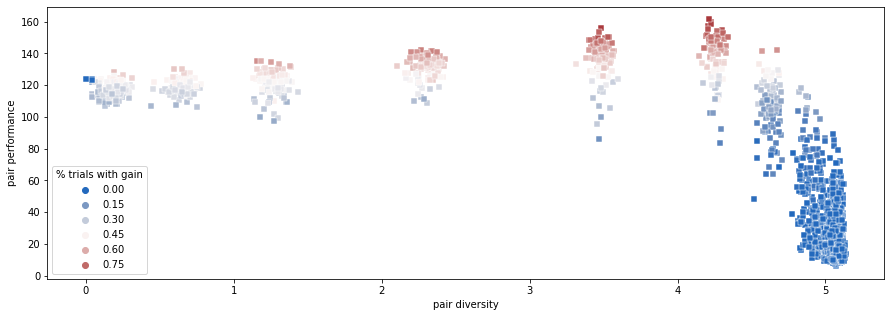

In [264]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=ag,
                x='diversity', 
                y='performance_pair_mean',
                hue='is_gain_mean', 
                palette='vlag', 
                marker='s')
plt.legend(title='% trials with gain')
plt.xlabel('pair diversity')
plt.ylabel('pair performance')
plt.show()

### Mean jump ~ diversity

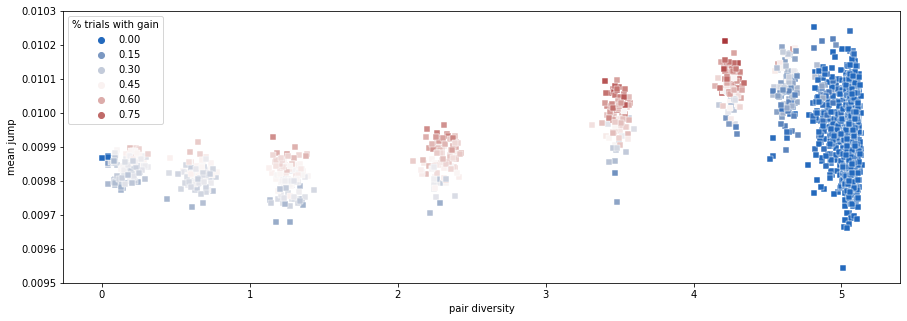

In [447]:
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=ag,
                x='diversity', 
                y='mean_jump_speaker',
                hue='is_gain_mean', 
                palette='vlag', 
                marker='s')
plt.legend(title='% trials with gain')
plt.xlabel('pair diversity')
plt.ylabel('mean jump')
plt.ylim(0.0095,0.0103)
plt.show()

### Gain as a function of difference in individual performance (trial-level analysis)

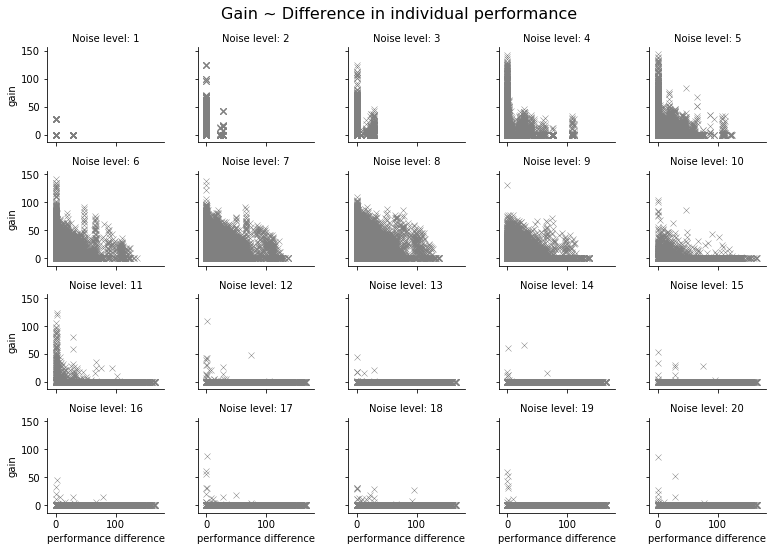

In [488]:
f = sns.relplot(data=pair_aggs,
                x='performance_difference_individuals', 
                y='pos_gain',
                col='noise_level_recoded', 
                col_wrap=5, 
                height=1.8, aspect=1.2, 
                marker='x', 
                color='grey')
f.set_axis_labels('performance difference', 'gain')
f.set_titles("Noise level: {col_name}")
plt.suptitle('Gain ~ Difference in individual performance', y=1.03, fontsize=16)
plt.show()

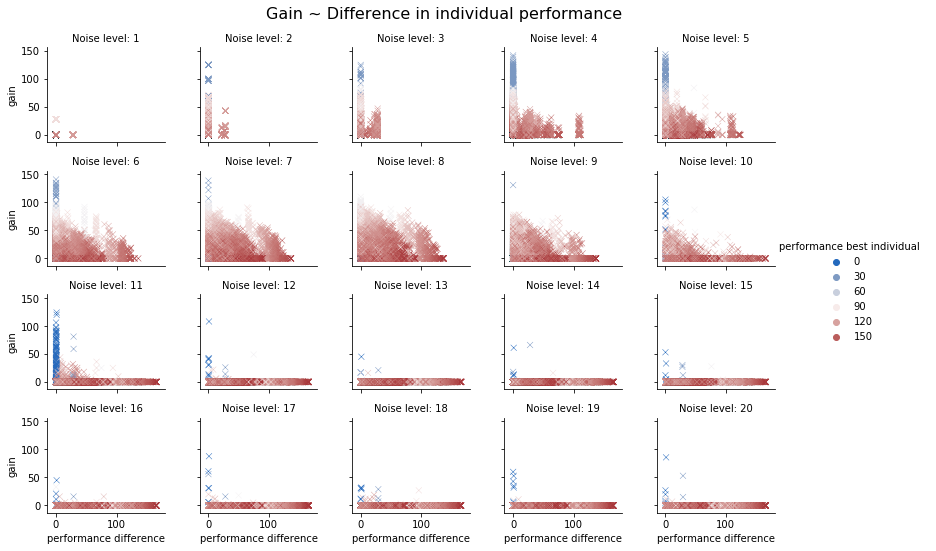

In [515]:
f = sns.relplot(data=pair_aggs,
                x='performance_difference_individuals', 
                y='pos_gain',
                col='noise_level_recoded', 
                col_wrap=5, 
                height=1.8, aspect=1.2, 
                marker='x', 
                color='grey', 
                hue='performance_best', 
                palette='vlag')
f.set_axis_labels('performance difference', 'gain')
f.set_titles('Noise level: {col_name}')
f._legend.set_title('performance best individual')
f._legend.set_bbox_to_anchor([1.06, 0.5]) 
plt.suptitle('Gain ~ Difference in individual performance', y=1.03, fontsize=16)
plt.show()

### Gain as a function of jump length (trial-level analysis)

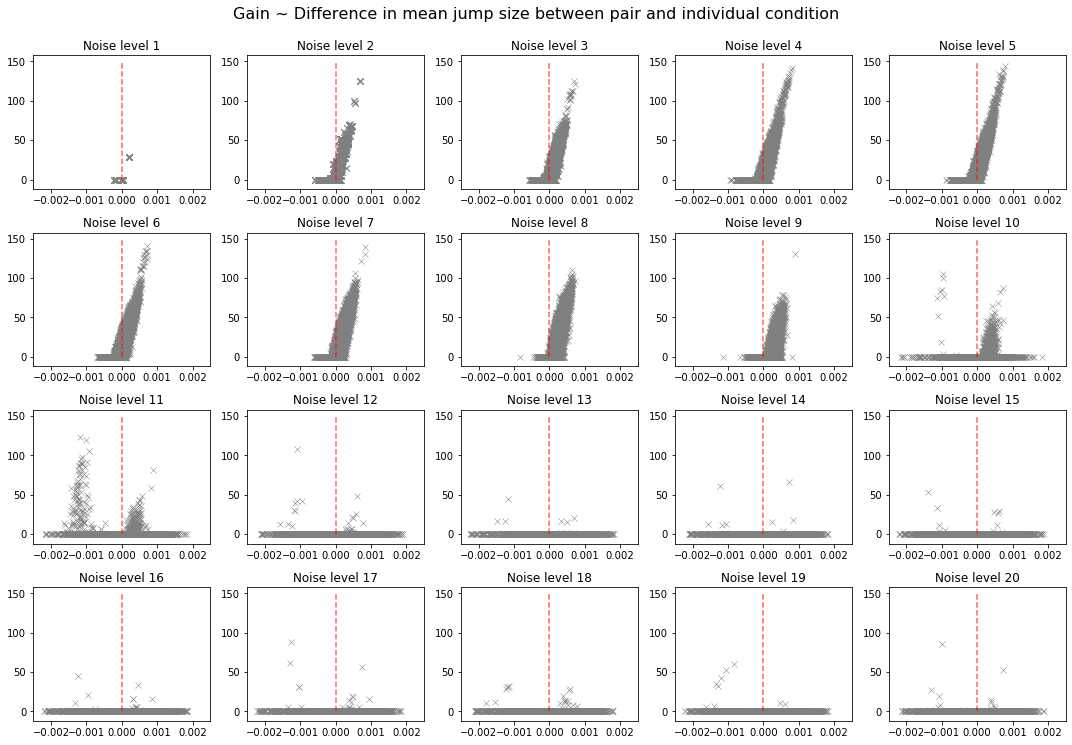

In [411]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))
idxs = itertools.product(range(4), range(5))
for p, i in zip(sorted(pair_aggs.noise_level_recoded.unique().tolist()), idxs):
    data = pair_aggs[pair_aggs['noise_level_recoded']==p].copy()
    ax[i].vlines([0], 0, 150, linestyles='dashed', colors='red', alpha=.6)
    sns.scatterplot(data=data,
                    x='pair_ind_jump_difference', # or jump? or alternation? 
                    y='pos_gain',
                    marker='x', 
                    color='grey', 
                    ax=ax[i], legend=False)
    ax[i].set_xlim(-0.0025, 0.0025)
    ax[i].set_title(f'Noise level {p}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.suptitle('Gain ~ Difference in mean jump size between pair and individual condition', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

### Relationship between jump length and "neighborhoods" visited (trial-level)

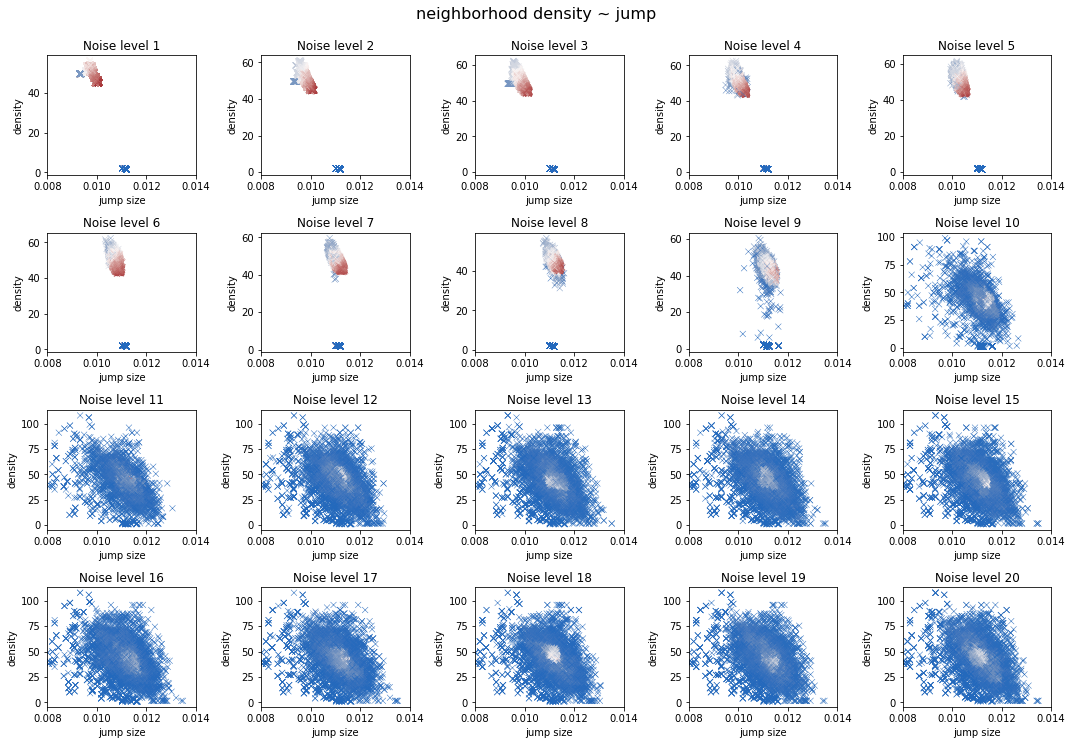

In [472]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))
idxs = itertools.product(range(4), range(5))
for p, i in zip(sorted(pair_aggs.noise_level_recoded.unique().tolist()), idxs):
    data = pair_aggs[pair_aggs['noise_level_recoded']==p].copy()
    sns.scatterplot(data=data,
                    x='mean_jump_0', 
                    y='mean_neighborhood_density_0',
                    palette='vlag',
                    hue='performance_pair',
                    marker='x', 
                    ax=ax[i], legend=False)
    ax[i].set_xlim(0.008, 0.014)
    ax[i].set_title(f'Noise level {p}')
    ax[i].set_xlabel('jump size')
    ax[i].set_ylabel('density')
plt.suptitle('neighborhood density ~ jump', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

### Jump ~ neighborhood density in individual condition

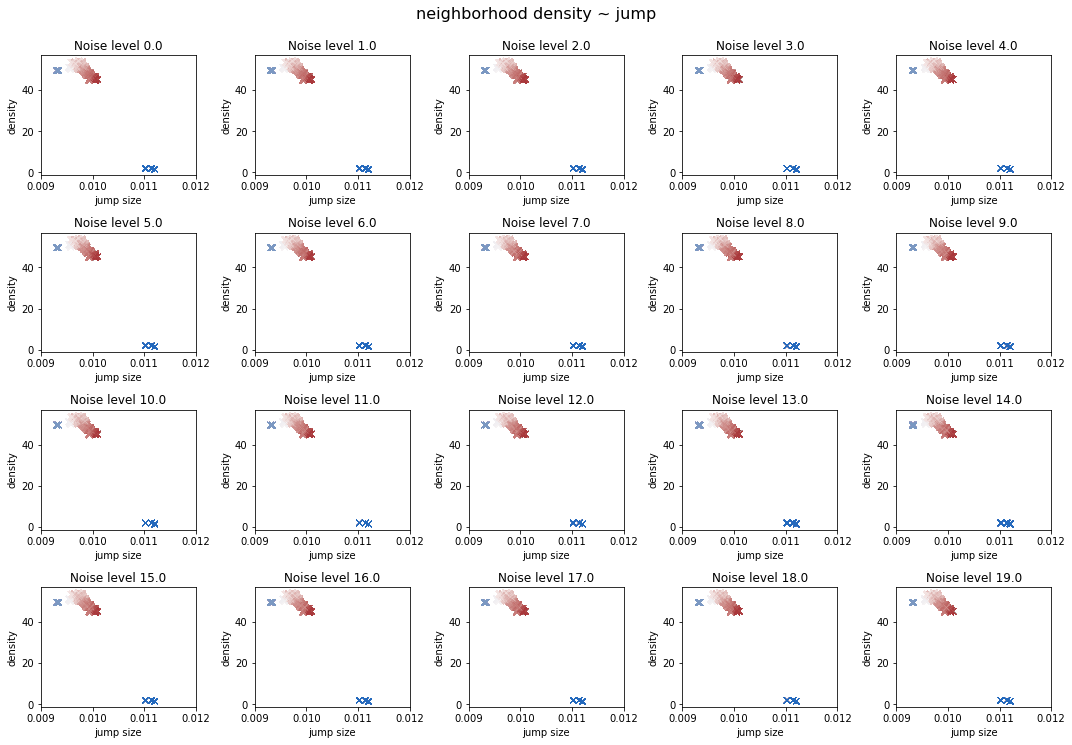

In [514]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))
idxs = itertools.product(range(4), range(5))
for p, i in zip(sorted(ind_aggs.noise_level.unique().tolist()), idxs):
    data = ind_aggs[ind_aggs['noise_level']==p].copy()
    sns.scatterplot(data=data,
                    x='mean_jump', 
                    y='mean_neighborhood_density',
                    palette='vlag',
                    hue='performance',
                    marker='x', 
                    ax=ax[i], legend=False)
    ax[i].set_xlim(0.009, 0.012)
    ax[i].set_title(f'Noise level {p}')
    ax[i].set_xlabel('jump size')
    ax[i].set_ylabel('density')
plt.suptitle('neighborhood density ~ jump', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

### Plot jump distribution for trials where there is gain

/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py

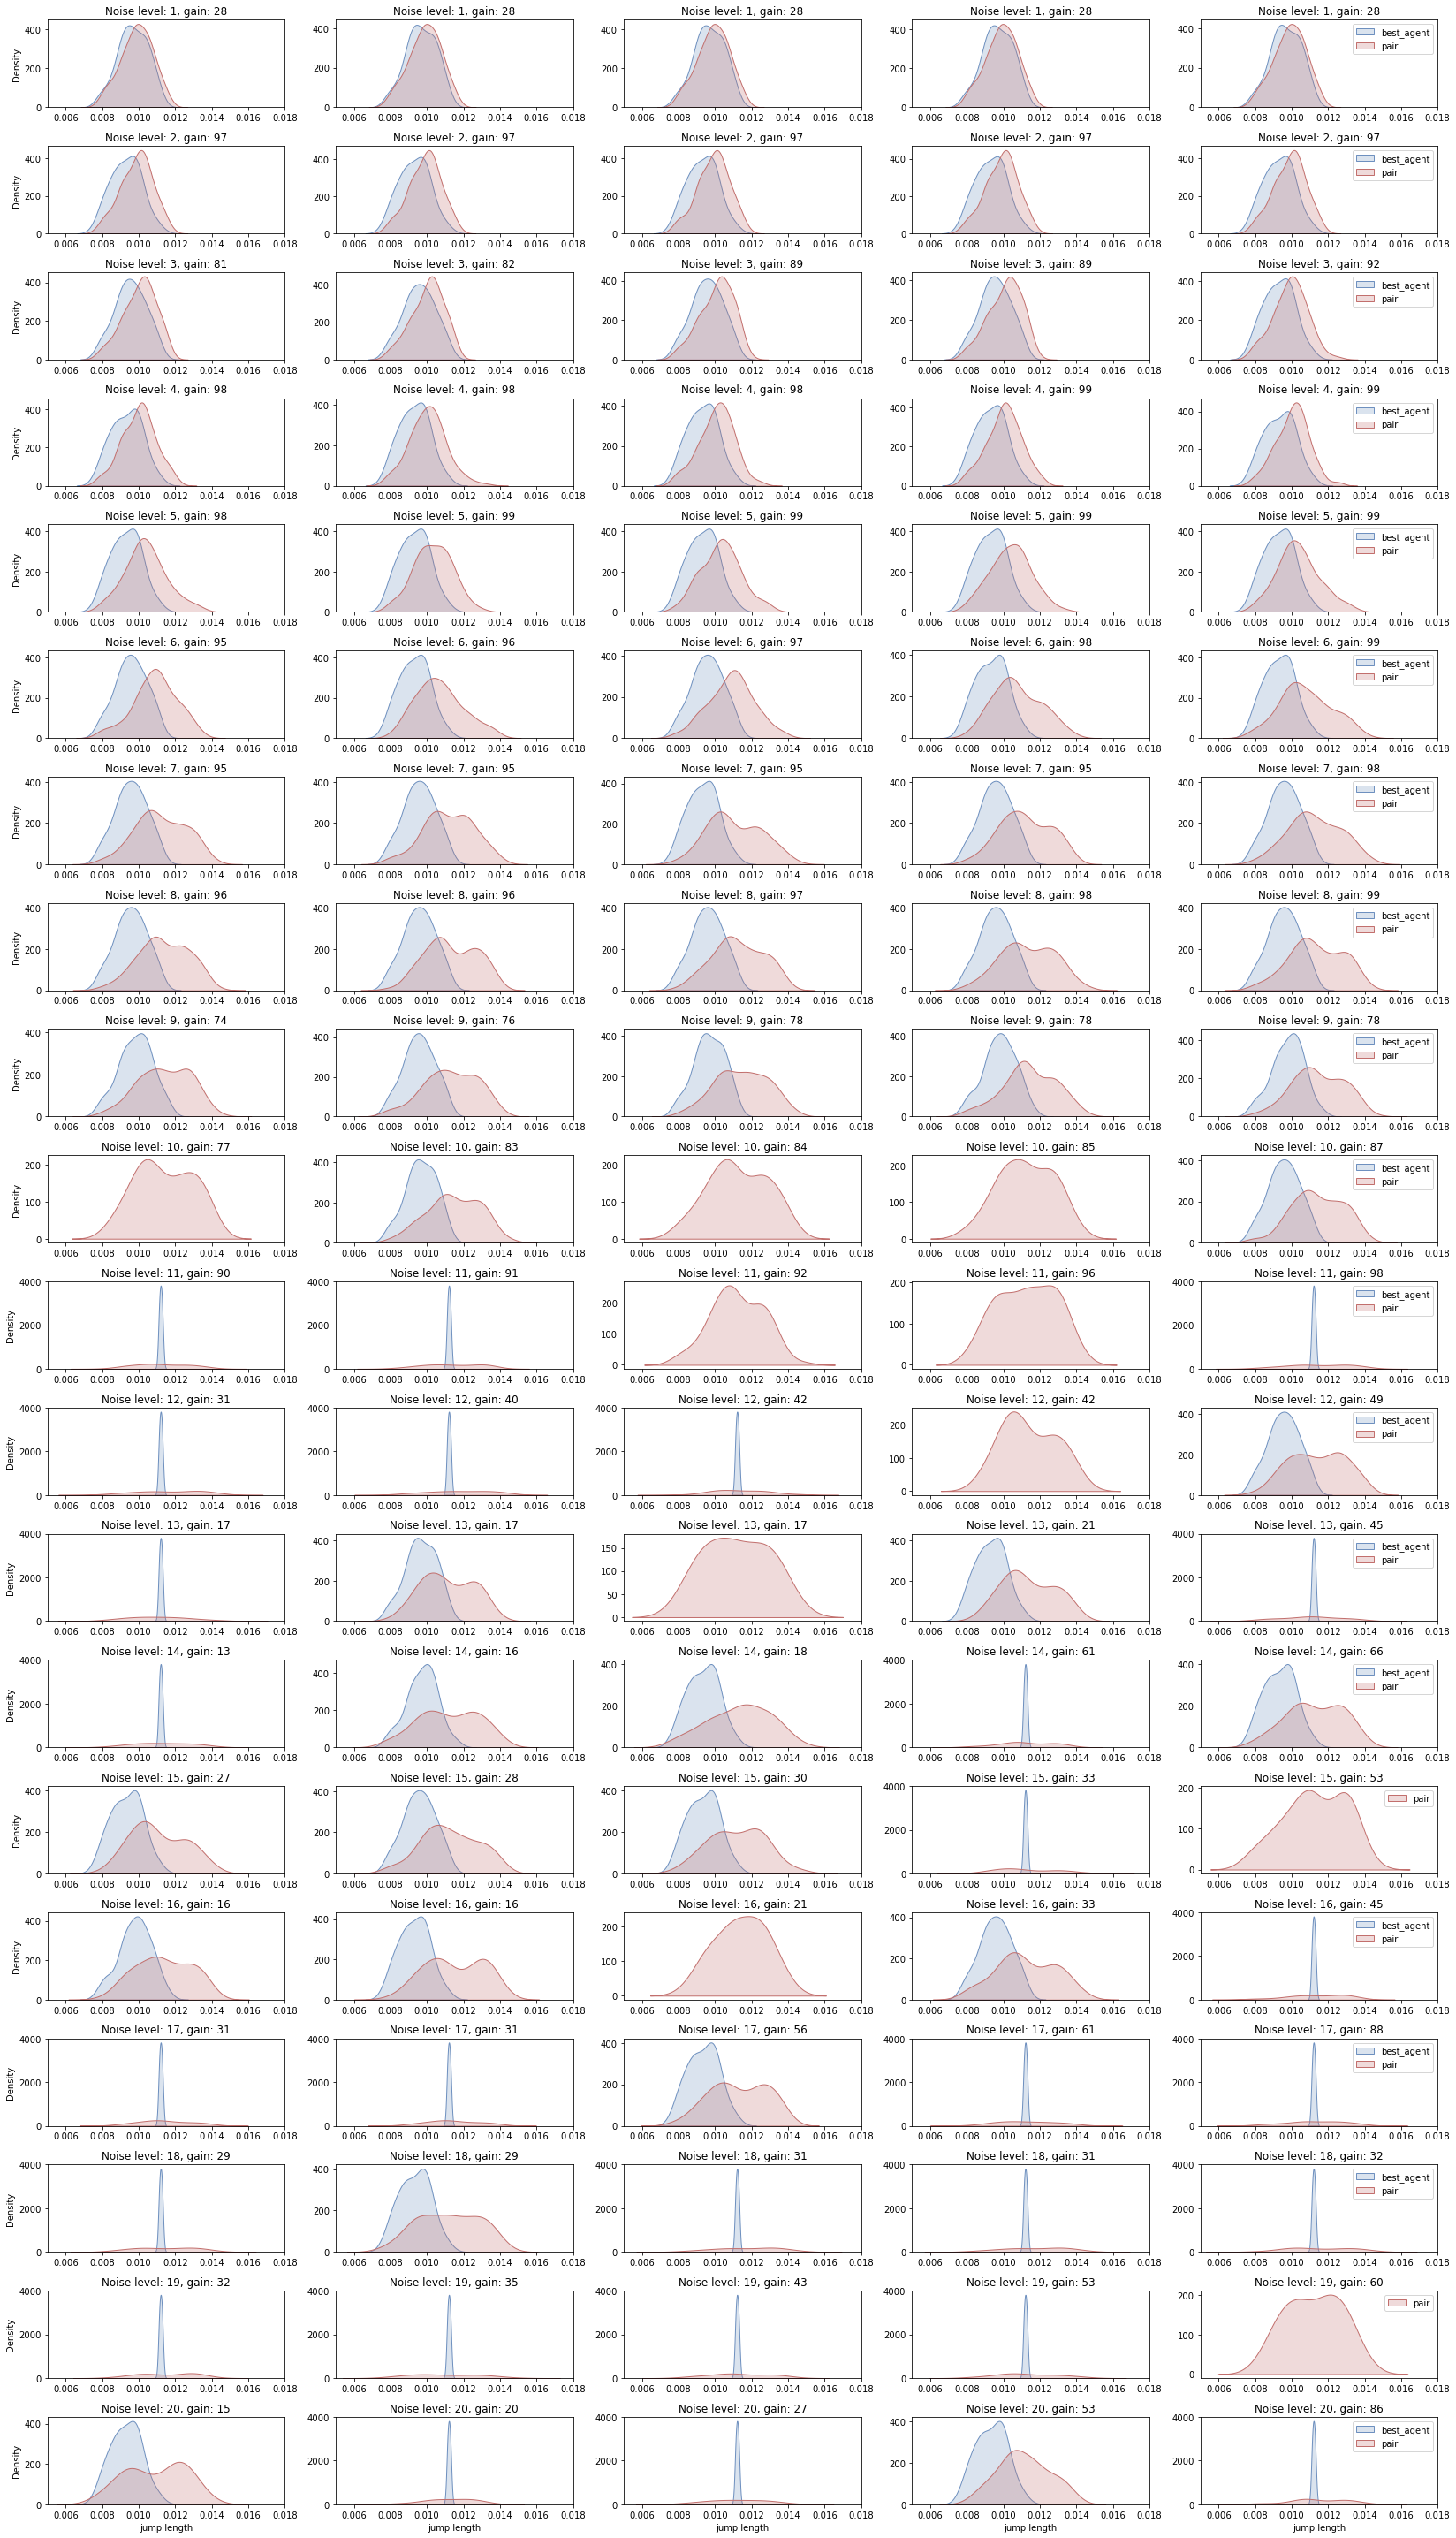

In [617]:
fig, ax = plt.subplots(nrows=20, ncols=5, figsize=(23,40))
bests = []
worsts = []
pair_aggs['best_agent'] = np.where(pair_aggs['performance_best']==pair_aggs['performance_a0'],
                                   pair_aggs['agent_0'], pair_aggs['agent_1'])
for bidx, b in enumerate(sorted(pair_aggs['noise_level_recoded'].unique().tolist())):
    data = pair_aggs[(pair_aggs['noise_level_recoded']==b) & (pair_aggs['amount_gain']<100) \
                     & (pair_aggs['amount_gain']>-100)]
    bests = data[['pair', 'amount_gain', 'best_agent', 'init_seed']].sort_values('amount_gain').tail(n=5)
    pairs_best = bests.pair.tolist()
    pairs_best_agent = bests.best_agent.tolist()
    pairs_best_seed = bests.init_seed.tolist()
    pairs_best_gain = bests.amount_gain.tolist()
    pbs = list(zip(pairs_best, pairs_best_agent, pairs_best_seed, pairs_best_gain))
    for idx, p in enumerate(pbs):
        pair = p[0]+'_2_0.01179.txt'
        agent = p[1]+'_1_0.01179.txt'
        seed = p[2]
        idf = pd.read_csv(f'{log_path}/{date}/individual/{agent}')
        sns.kdeplot(x=idf[idf['init_seed']==seed].prob0, 
                     color=sns.color_palette('vlag')[0], 
                     label='best_agent', 
                     ax=ax[(bidx, idx)], 
                    fill=True)
        pdf = pd.read_csv(f'{log_path}/{date}/pairs/{pair}')
        sns.kdeplot(x=pdf[pdf['init_seed']==seed].prob0, 
                     color=sns.color_palette('vlag')[-1], 
                     label='pair', 
                     ax=ax[(bidx, idx)],
                    fill=True)
        ax[(bidx, idx)].set_title(f'Noise level: {b}, gain: {p[3]}')
        if idx != 0:
            ax[(bidx, idx)].set_ylabel('')
        if idx == 4:
            ax[(bidx, idx)].legend(loc='upper right')
        if bidx != 19:
            ax[(bidx, idx)].set_xlabel('')
        else:
            ax[(bidx, idx)].set_xlabel('jump length')
        ax[(bidx, idx)].set_xlim(0.005, 0.018)
plt.tight_layout()
plt.show()

### Visualize some examples

In [642]:
for bidx, b in enumerate(sorted(pair_aggs['noise_level_recoded'].unique().tolist())):
    data = pair_aggs[pair_aggs['noise_level_recoded']==b]
    print(f'\033[1m\033[34mNoise level: {b}\033[0m')
    sampled = data.sample(n=3, random_state=0)
    pairs_best = sampled.pair.tolist()
    pairs_best_agent = sampled.best_agent.tolist()
    pairs_best_seed = sampled.init_seed.tolist()
    pairs_best_gain = sampled.amount_gain.tolist()
    pbs = list(zip(pairs_best, pairs_best_agent, pairs_best_seed, pairs_best_gain))
    for idx, p in enumerate(pbs):
        pair = p[0]+'_2_0.01179.txt'
        agent = p[1]+'_1_0.01179.txt'
        seed = p[2]
        idf = pd.read_csv(f'{log_path}/{date}/individual/{agent}')
        ilist = idf[idf['init_seed']==seed].response.tolist()
        pdf = pd.read_csv(f'{log_path}/{date}/pairs/{pair}')
        plist = pdf[pdf['init_seed']==seed].response.tolist()
        print('\033[1mIndividual\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(ilist[:20]))
        print('\033[1mPair\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(plist[:20]) + '\n')

Noise level: 1
Individual: goat, cow, pig, chicken, duck, goose, pheasant, deer, elk, antelope, bison, black_bear, grizzly_bear, polar_bear, killer_whale, sperm_whale, blue_whale, fin_whale, whale, dolphin, shark
Pair: goat, cow, pig, chicken, duck, goose, pheasant, deer, elk, antelope, bison, black_bear, grizzly_bear, polar_bear, killer_whale, sperm_whale, blue_whale, fin_whale, whale, dolphin, shark

Individual: grasshopper, beetle, cockroach, harvestman, millipede, saurian, anteater, armadillo, alligator, crocodile, shark, dolphin, whale, blue_whale, sperm_whale, fin_whale, killer_whale, polar_bear, grizzly_bear, black_bear, tapir
Pair: grasshopper, beetle, cockroach, harvestman, millipede, saurian, anteater, armadillo, alligator, crocodile, shark, dolphin, whale, blue_whale, sperm_whale, fin_whale, killer_whale, polar_bear, grizzly_bear, black_bear, tapir

Individual: mongoose, gerbil, sea_snake, coral_snake, diamondback_rattlesnake, cottonmouth, copperhead, rattlesnake, snake, liz

### Print sample sequences where pairs do better

In [670]:
for bidx, b in enumerate(sorted(pair_aggs['noise_level_recoded'].unique().tolist())):
    data = pair_aggs[pair_aggs['noise_level_recoded']==b]
    print(f'\033[1m\033[34mNoise level: {b}\033[0m')
    sampled = data[data['amount_gain']>0].sample(2).sort_values('amount_gain')
    pairs_best = sampled.pair.tolist()
    pairs_best_agent = sampled.best_agent.tolist()
    pairs_best_seed = sampled.init_seed.tolist()
    pairs_best_gain = sampled.amount_gain.tolist()
    pbs = list(zip(pairs_best, pairs_best_agent, pairs_best_seed, pairs_best_gain))
    for idx, p in enumerate(pbs):
        print(f'\033[1mAmount gain: {p[3]}\033[0m')
        pair = p[0]+'_2_0.01179.txt'
        agent = p[1]+'_1_0.01179.txt'
        seed = p[2]
        idf = pd.read_csv(f'{log_path}/{date}/individual/{agent}')
        ilist = idf[idf['init_seed']==seed].response.tolist()
        pdf = pd.read_csv(f'{log_path}/{date}/pairs/{pair}')
        plist = pdf[pdf['init_seed']==seed].response.tolist()
        print('\033[1mIndividual\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(ilist))
        print('\033[1mPair\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(plist) + '\n')

Noise level: 1
Amount gain: 28
Individual: blue_whale, sperm_whale, killer_whale, fin_whale, whale, dolphin, shark, squid, cuttlefish, sawfish, sea_snake, coral_snake, diamondback_rattlesnake, cottonmouth, copperhead, rattlesnake, snake, lizard, toad, frog, salamander, turtle, tortoise, elephant, rhinoceros, giraffe, baboon, hyena, polecat, weasel, rabbit, dog, cat, poodle, dachshund, pekingese, hamster, guinea_pig, chimpanzee, bonobo, okapi, gazelle, leopard, tiger, lion, eagle, hawk, sparrow, parrot, parakeet, pheasant, deer, elk, antelope, bison, black_bear, grizzly_bear, polar_bear, red_panda, bengal_tiger, gorilla, monkey, rat, mouse, squirrel, porcupine, owl, wolf, coyote, beaver, otter, trout, salmon, halibut, plaice, lobster, crab, prawn, shrimp, oyster, scallop, shell, snail, slug, starfish, jellyfish, octopus, anteater, armadillo, alligator, crocodile, platypus, koala, wombat, dingo, kangaroo, kiwi
Pair: blue_whale, sperm_whale, fin_whale, whale, dolphin, killer_whale, polar_

### Print sample sequences where pairs do worse

In [672]:
for bidx, b in enumerate(sorted(pair_aggs['noise_level_recoded'].unique().tolist())):
    data = pair_aggs[pair_aggs['noise_level_recoded']==b]
    print(f'\033[1m\033[34mNoise level: {b}\033[0m')
    sampled = data[data['amount_gain']<0].sample(2).sort_values('amount_gain')
    pairs_best = sampled.pair.tolist()
    pairs_best_agent = sampled.best_agent.tolist()
    pairs_best_seed = sampled.init_seed.tolist()
    pairs_best_gain = sampled.amount_gain.tolist()
    pbs = list(zip(pairs_best, pairs_best_agent, pairs_best_seed, pairs_best_gain))
    for idx, p in enumerate(pbs):
        print(f'\033[1mAmount gain\033[0m: {p[3]}')
        pair = p[0]+'_2_0.01179.txt'
        agent = p[1]+'_1_0.01179.txt'
        seed = p[2]
        idf = pd.read_csv(f'{log_path}/{date}/individual/{agent}')
        idf = idf[idf['init_seed']==seed]
        ilist = idf.response.tolist()
        ilast = idf.ndens0.tolist()[-1]
        pdf = pd.read_csv(f'{log_path}/{date}/pairs/{pair}')
        pdf = pdf[pdf['init_seed']==seed]
        plist = pdf.response.tolist()
        print('\033[1mIndividual\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(ilist))
        print('\033[1mPair\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(plist) + '\n')

Noise level: 1
Amount gain: -56
Individual: armadillo, anteater, harvestman, millipede, saurian, sea_cow, blue_whale, sperm_whale, killer_whale, fin_whale, whale, dolphin, shark, squid, cuttlefish, sawfish, sea_snake, coral_snake, diamondback_rattlesnake, cottonmouth, copperhead, rattlesnake, snake, lizard, toad, frog, salamander, turtle, tortoise, elephant, rhinoceros, giraffe, baboon, hyena, polecat, weasel, rabbit, dog, cat, poodle, dachshund, pekingese, hamster, guinea_pig, chimpanzee, bonobo, okapi, gazelle, leopard, tiger, lion, eagle, hawk, sparrow, parrot, parakeet, pheasant, deer, elk, antelope, bison, black_bear, grizzly_bear, polar_bear, red_panda, bengal_tiger, gorilla, monkey, rat, mouse, squirrel, porcupine, owl, wolf, coyote, beaver, otter, trout, salmon, halibut, plaice, lobster, crab, prawn, shrimp, oyster, scallop, shell, snail, slug, starfish, jellyfish, octopus, spider, tarantula, scorpion, panther, piranha, crocodile, alligator, eel, catfish, carp, perch, barbel, c

Bottom line: diversity can help avoiding local minima in the space. However, it can occasionally contribute to speeding up convergence towards those local minima (something that is not a local minimum for an agent, which names is, may be so for others).

### Display some semantic spaces

### Plot some pair-best behavior

In [ ]:
# Display some semantic spaces of individuals per noise level
# Plot some pair behavior 

### Plot some individual trial

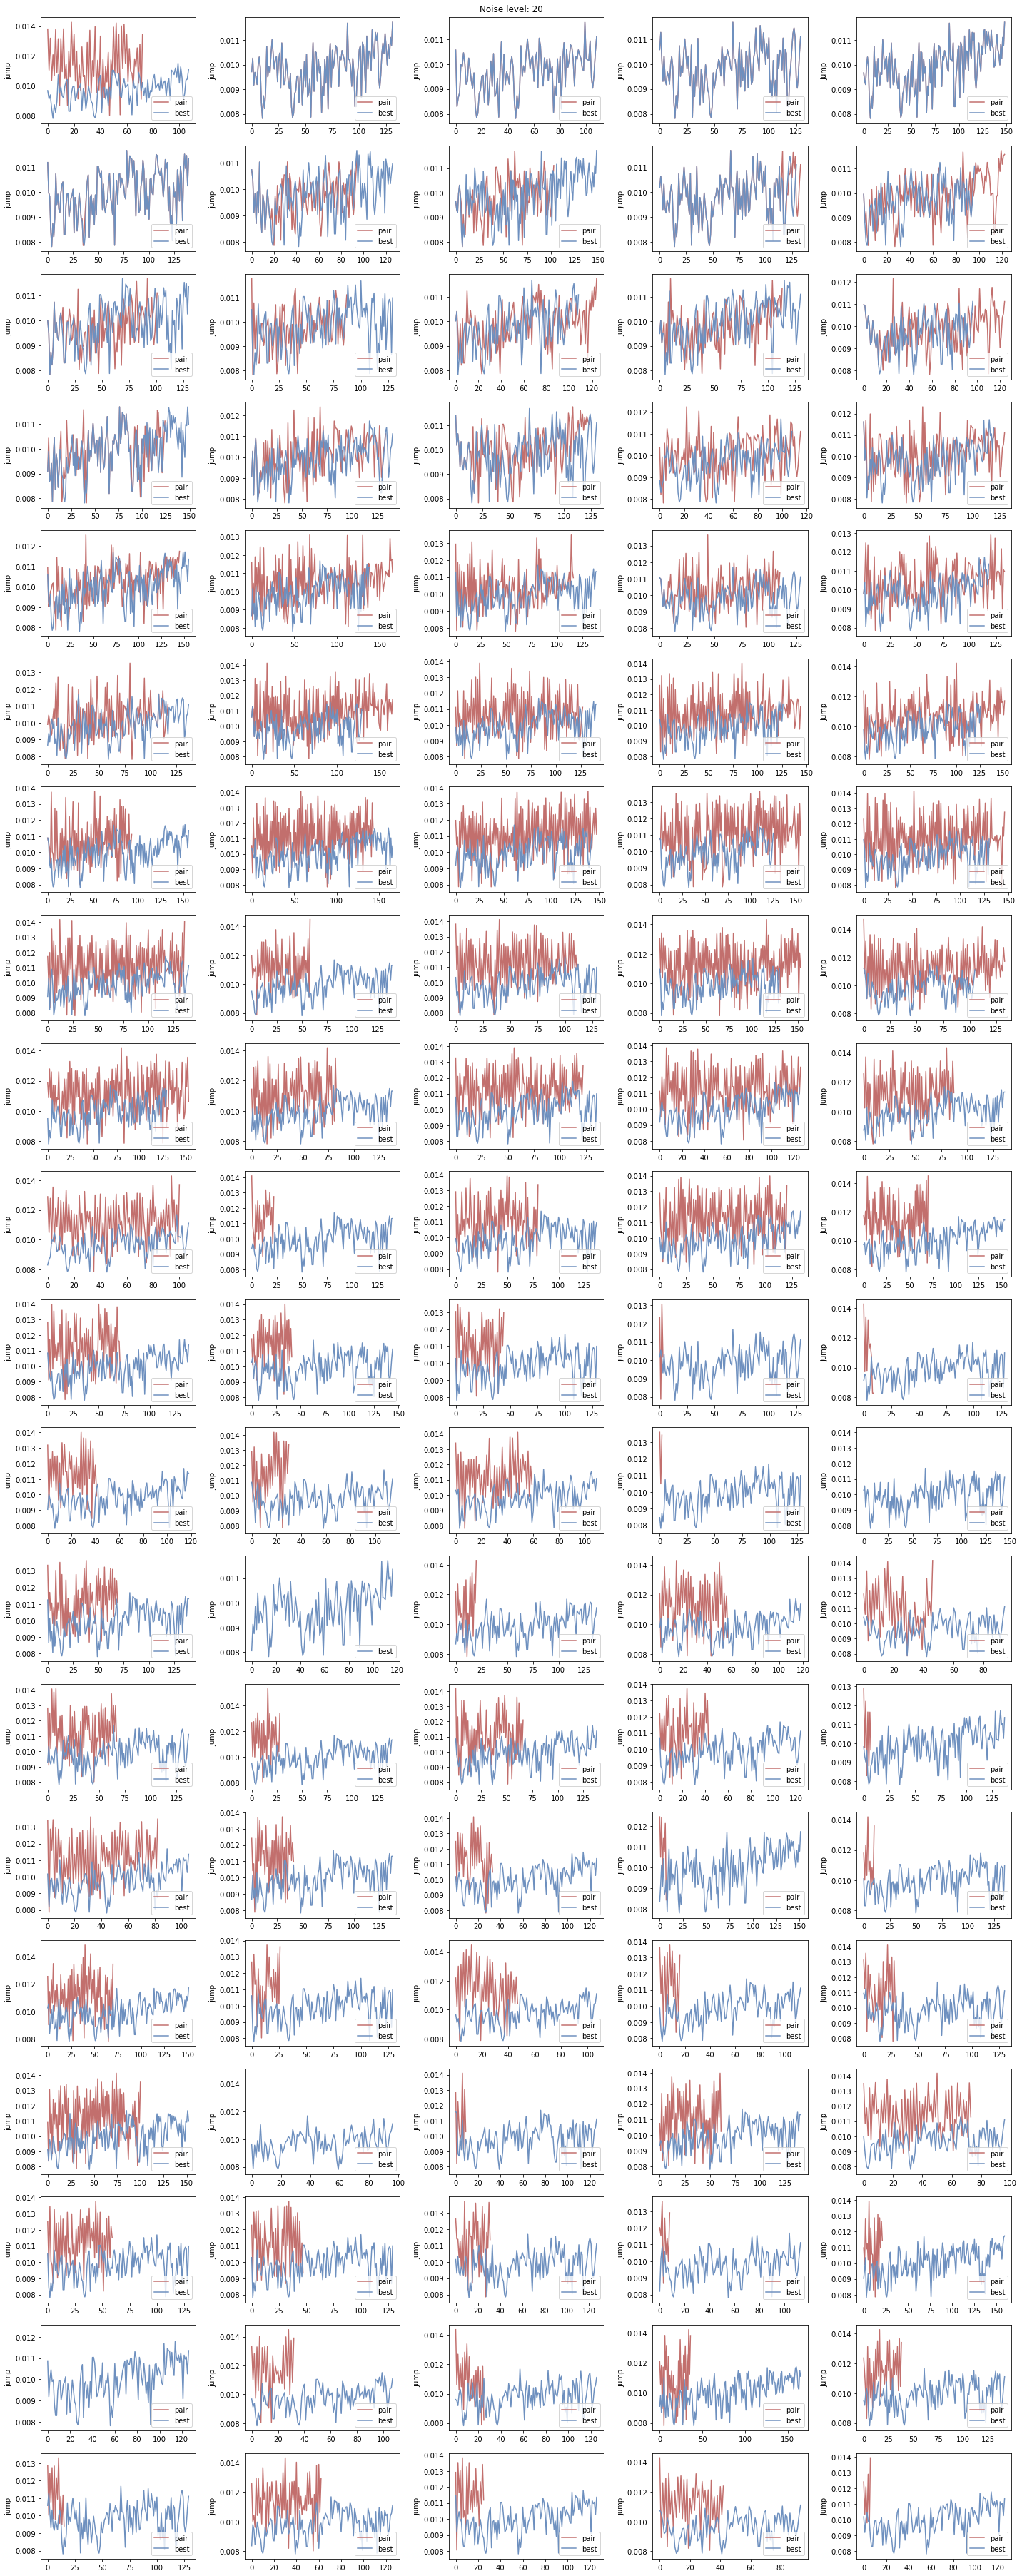

In [716]:
fig, ax = plt.subplots(nrows=20, ncols=5, figsize=(20,50))
for bidx, b in enumerate(sorted(pair_aggs['noise_level_recoded'].unique().tolist())):
    data = pair_aggs[(pair_aggs['noise_level_recoded']==b) & (pair_aggs['amount_gain']<100) \
                     & (pair_aggs['amount_gain']>-100)]
    bests = data[['pair', 'amount_gain', 'best_agent', 'init_seed']].sample(n=5).sort_values('amount_gain')
    pairs_best = bests.pair.tolist()
    pairs_best_agent = bests.best_agent.tolist()
    pairs_best_seed = bests.init_seed.tolist()
    pairs_best_gain = bests.amount_gain.tolist()
    pbs = list(zip(pairs_best, pairs_best_agent, pairs_best_seed, pairs_best_gain))
    for idx, p in enumerate(pbs):
        pair = p[0]+'_2_0.01179.txt'
        agent = p[1]+'_1_0.01179.txt'
        seed = p[2]
        if p[1] == pair_aggs['agent_0'].iloc[0]:
            pbs = 'prob0'
        else:
            pbs = 'prob1'
        idf = pd.read_csv(f'{log_path}/{date}/individual/{agent}')
        sns.lineplot(data=pdf[pdf['init_seed']==seed].reset_index(),
                     y=pbs, 
                     x=range(pdf[pdf['init_seed']==seed].shape[0]),
                     label='pair', 
                     ax=ax[(bidx, idx)], 
                     color=sns.color_palette('vlag')[-1])
        pdf = pd.read_csv(f'{log_path}/{date}/pairs/{pair}')
        sns.lineplot(data=idf[idf['init_seed']==seed].reset_index(),
                     y='prob0', 
                     x=range(idf[idf['init_seed']==seed].shape[0]),
                     label='best', 
                     ax=ax[(bidx, idx)], 
                     color=sns.color_palette('vlag')[0])
        ax[(bidx, idx)].set_ylabel('jump')
        ax[(bidx, idx)].legend(loc='lower right')
    plt.suptitle(f'Noise level: {b}', y=1.002)
plt.tight_layout()
plt.show()

### Check where trials end

In [746]:
counted_last = pair_aggs.groupby(['noise_level_recoded', 
                                  'last_response_pair'])['pair'].count().reset_index()
counted_last.rename({'pair': 'count'}, axis=1, inplace=True)

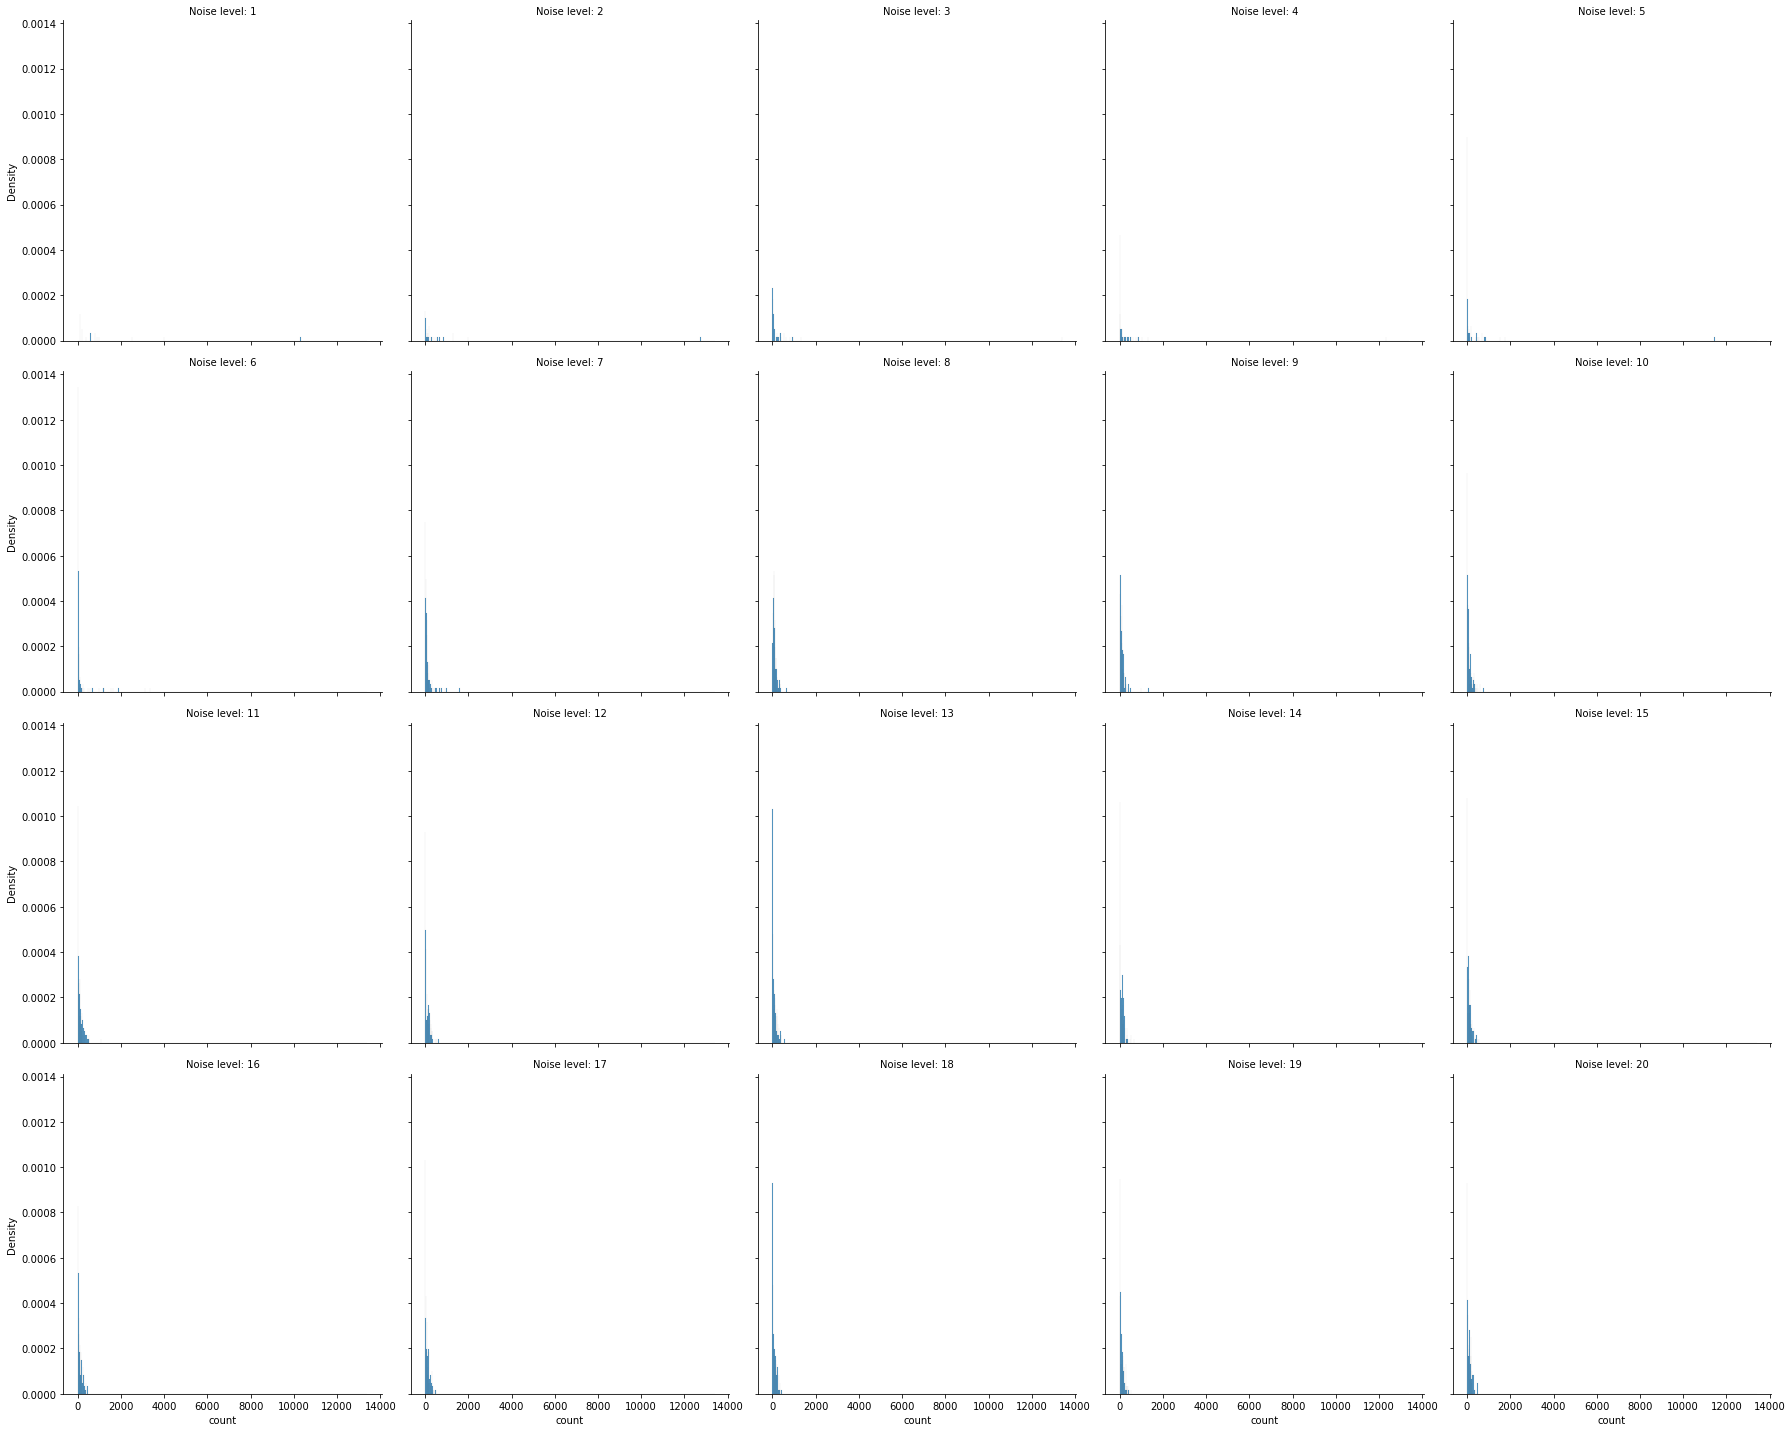

In [749]:
f = sns.displot(data=counted_last, 
                x='count', 
                col='noise_level_recoded', 
                col_wrap=5, 
                stat='density')
for a in f.axes:
    
f.set_titles('Noise level: {col_name}')

In [717]:
# Plot some of the paths in space
# Plot some of the spaces

In [417]:
trial_df = pd.read_csv([f for f in pair_fs if pairs in f][0])
a1_df = pd.read_csv([f for f in fs if agents1 in f][0]) # this is the right agent
a2_df = pd.read_csv([f for f in fs if agents2 in f][0])
space_df = pd.read_csv('animal_game/models/21_06_11/noised_vectors/wiki_0_430.tsv', 
                       sep='\t', index_col=0)

In [418]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)
scaled_vecs = StandardScaler().fit_transform(space_df)
embedding = reducer.fit_transform(scaled_vecs)

In [419]:
adict = dict(zip(space_df.index, 
                 range(len(space_df.index))))

In [420]:
named_individual = a1_df[a1_df['init_seed']==init_seeds].seed.tolist()
named_idx_individual = [adict[i] for i in named_individual]
xs_individual = [embedding[n,0] for n in named_idx_individual]
ys_individual = [embedding[n,1] for n in named_idx_individual]

In [421]:
named_pair = trial_df[trial_df['init_seed']==init_seeds].seed.tolist()
named_idx_pair = [adict[i] for i in named_pair]
xs_pair = [embedding[n,0] for n in named_idx_pair]
ys_pair = [embedding[n,1] for n in named_idx_pair]

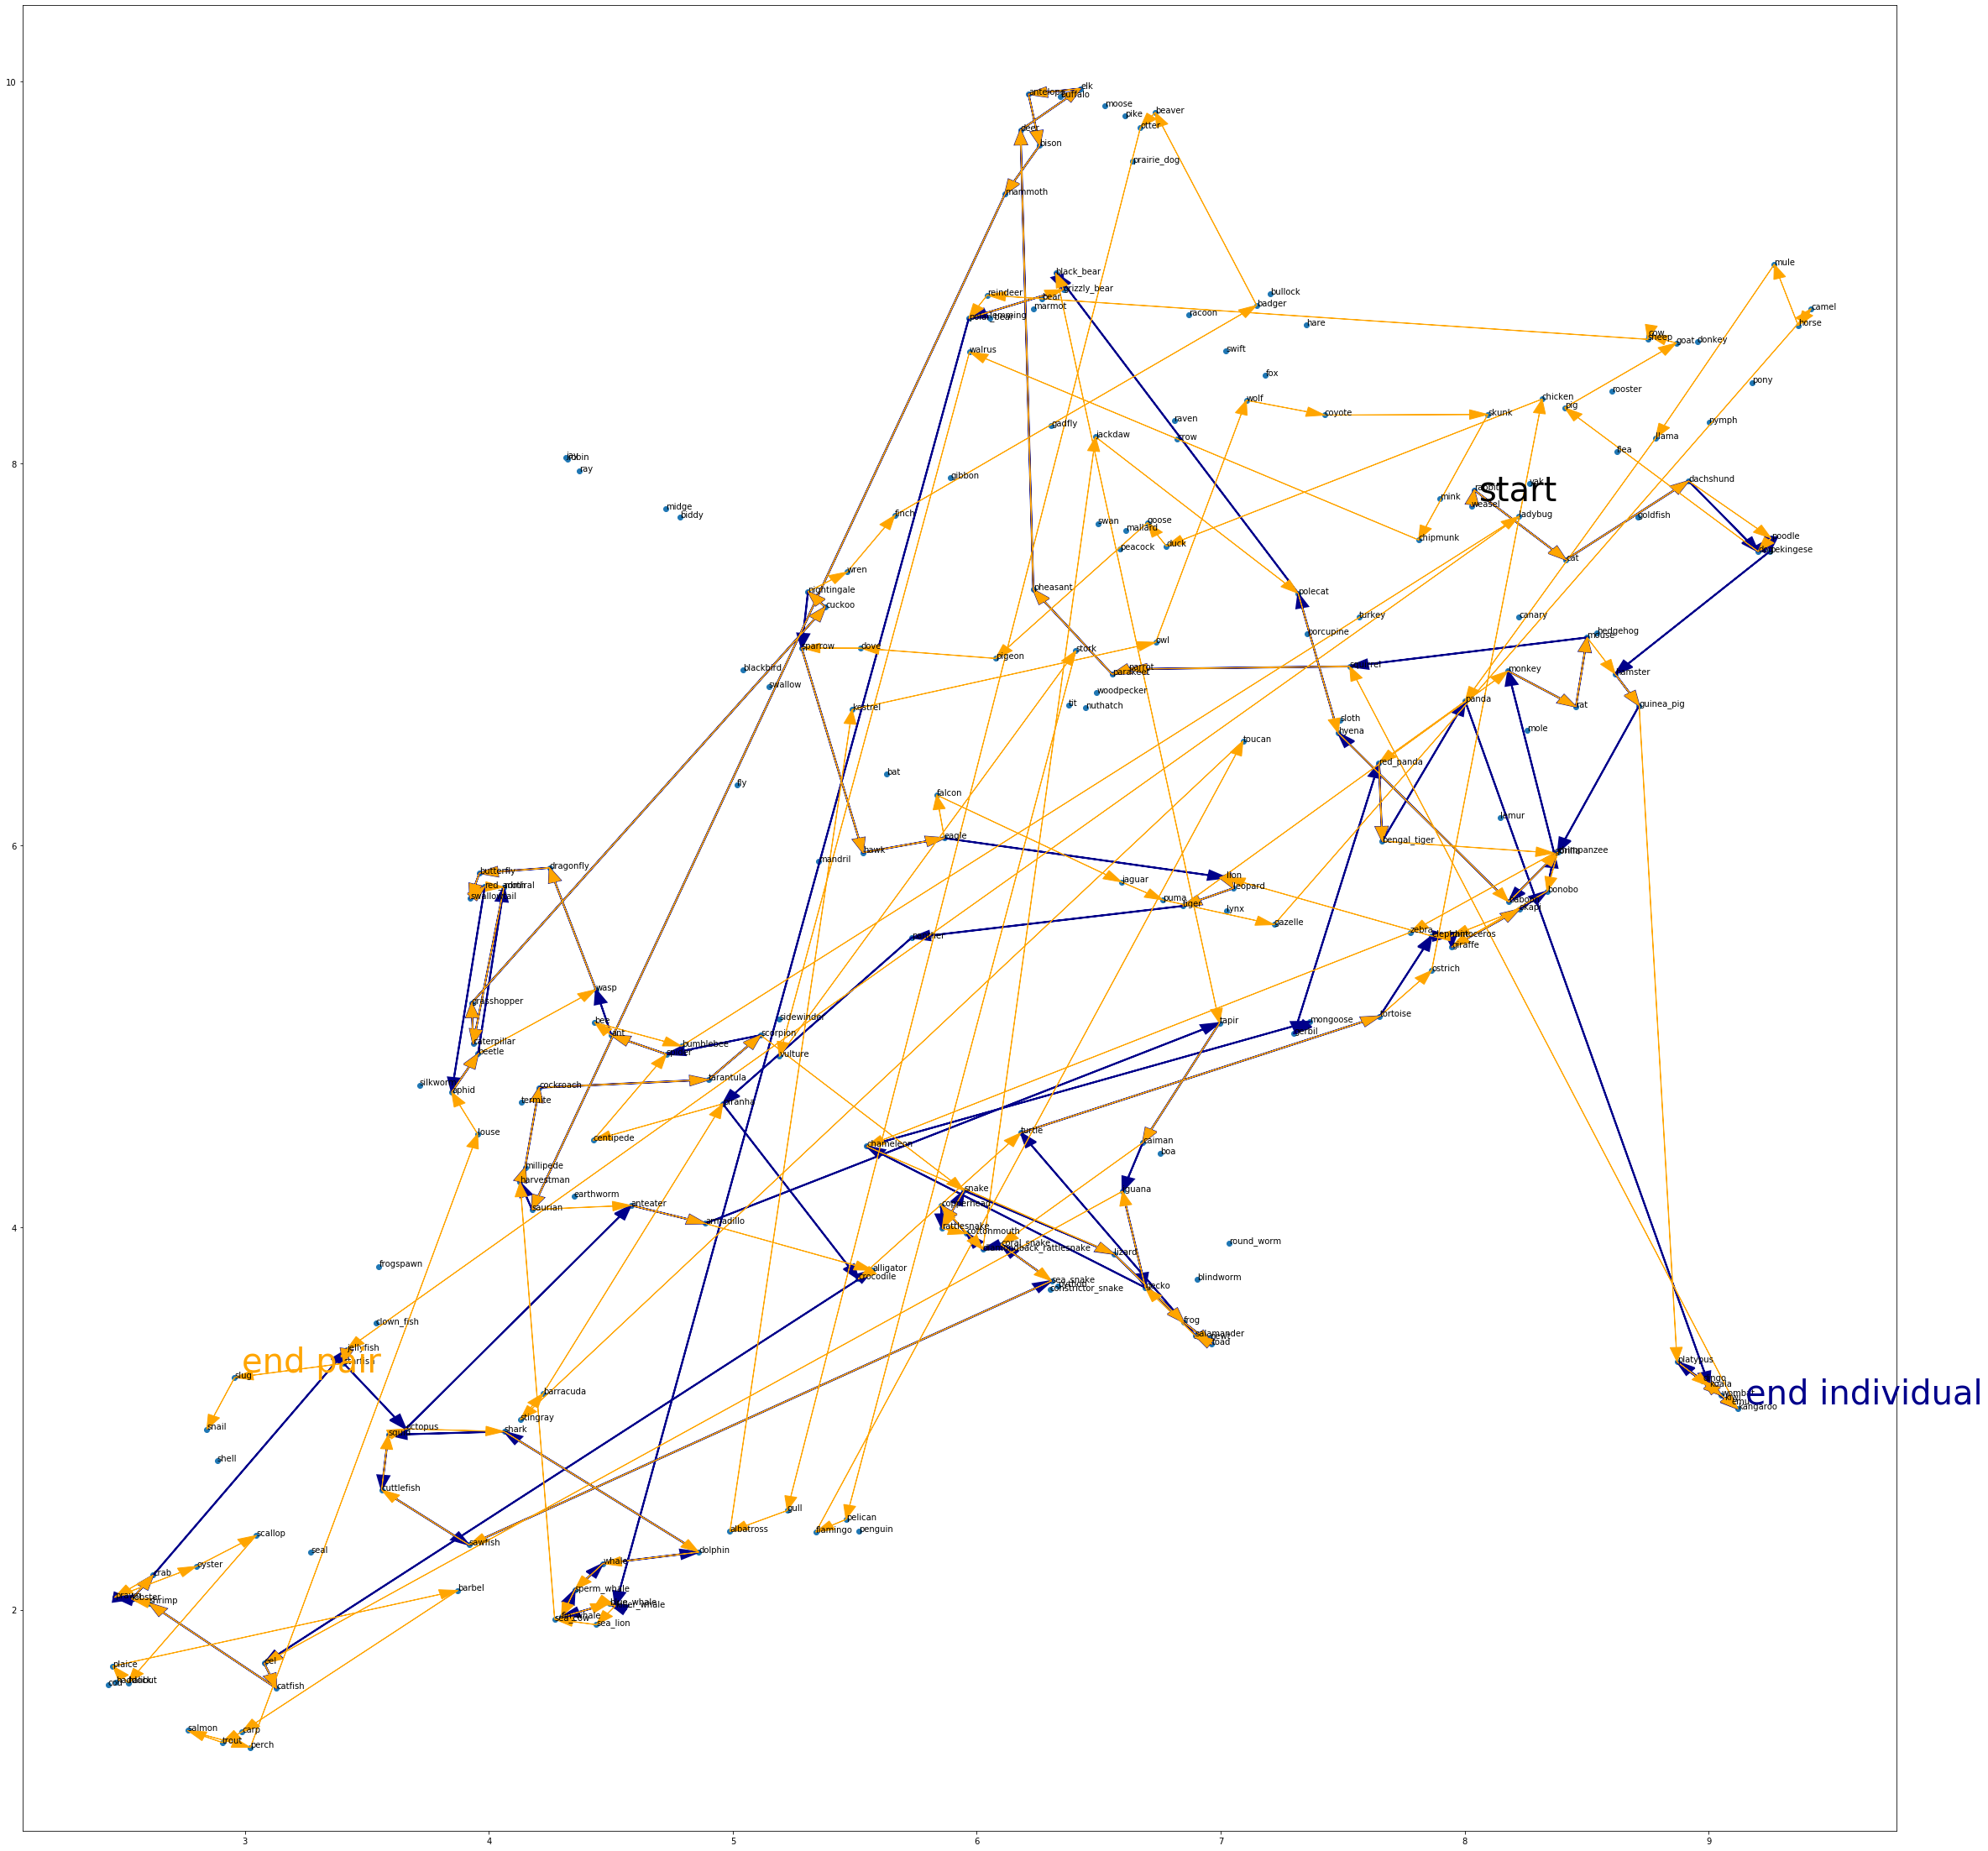

In [422]:
f, ax = plt.subplots(figsize=(40,40))
plt.scatter(embedding[:,0], embedding[:,1])
for idx, e in enumerate(embedding):
    plt.annotate(space_df.index[idx], e)
for idx in range(len(xs_individual)-1):
    plt.arrow(x=xs_individual[idx], 
              y=ys_individual[idx], 
              dx=xs_individual[idx+1]-xs_individual[idx],
              dy=ys_individual[idx+1]-ys_individual[idx],
              shape='full', lw=2,
              length_includes_head=True, head_width=.05, 
              color='darkblue')
    if idx == len(xs_individual)-2:
        plt.annotate('end individual',
                     (xs_individual[idx+1]+.03, ys_individual[idx+1]+.03),
                     fontsize=40, 
                     color='darkblue')
        
for idx in range(len(xs_pair)-1):
    if idx == 0:
        plt.annotate('start',
                     (xs_pair[idx]+.03, ys_pair[idx]+.03),
                     fontsize=40, 
                     color='black')
    plt.arrow(x=xs_pair[idx], 
              y=ys_pair[idx], 
              dx=xs_pair[idx+1]-xs_pair[idx],
              dy=ys_pair[idx+1]-ys_pair[idx],
              shape='full', 
              lw=1,
              length_includes_head=True, 
              head_width=.05, 
              color='orange')
    if idx == len(xs_pair)-2:
        plt.annotate('end pair',
                     (xs_pair[idx]+.03, ys_pair[idx]+.03),
                     fontsize=40, 
                     color='orange')
        
plt.show()

### Analysis
#### Define Steps


### Neighborhood density

## Individual trials dynamics

In [ ]:
# Look at alternation and how it impacts performance (for both agents) 
    # - also look at whether difference in that from that in individual impacts performance
# Look at difference in mean jumps between best individual and pair (and how it affects performance)
# Look at what cutoff for above is

In [90]:
df['prob_speaker'] = np.where(df['agent'] == 'wiki_0_305', df['prob0'], df['prob1'])
df['prob_listener'] = np.where(df['agent'] == 'wiki_0_305', df['prob1'], df['prob0'])
df['ndens_speaker'] = np.where(df['agent'] == 'wiki_0_305', df['ndens0'], df['ndens1'])
df['ndens_listener'] = np.where(df['agent'] == 'wiki_0_305', df['ndens1'], df['ndens0'])

df['prob_difference'] = df['prob_listener'] - df['prob_speaker']
df['ndens_difference'] = (df['ndens_listener'] - df['ndens_speaker']) / 100

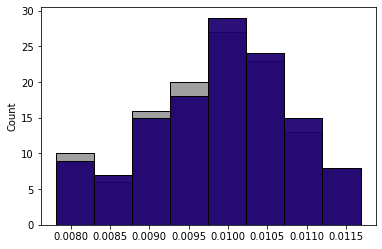

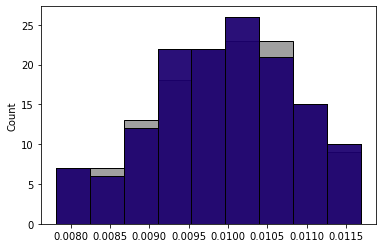

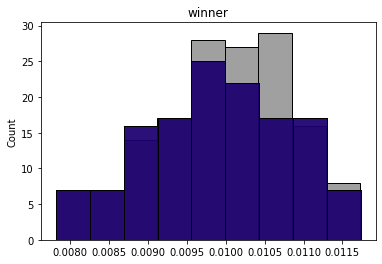

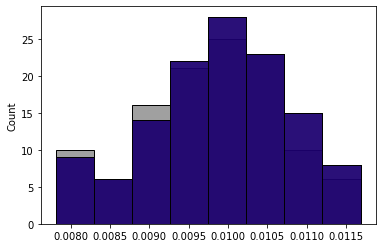

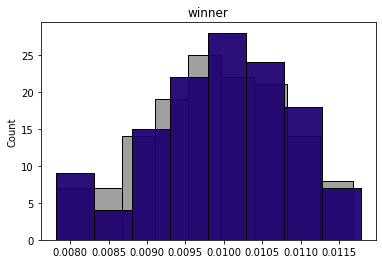

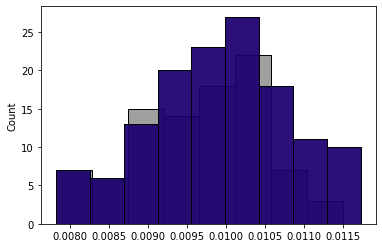

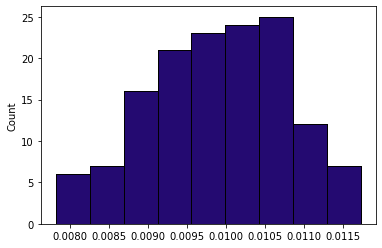

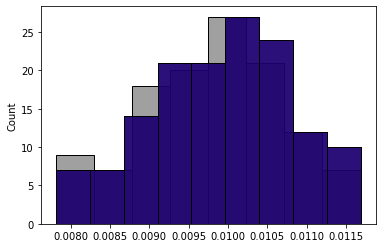

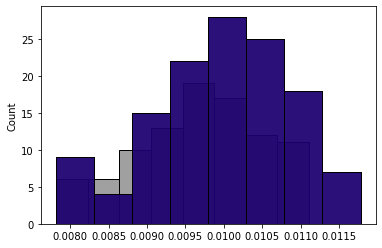

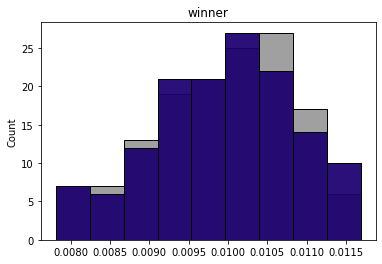

In [107]:
for i in range(10):
    sns.histplot(x=df[df['iter']==i].prob_speaker.tolist(), color='grey')
    sns.histplot(x=sdf[sdf['iter']==i].prob0.tolist(), color='darkred')
    sns.histplot(x=sdf2[sdf2['iter']==i].prob0.tolist(), color='darkblue')
    plt.show()

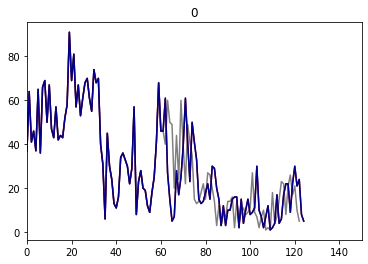

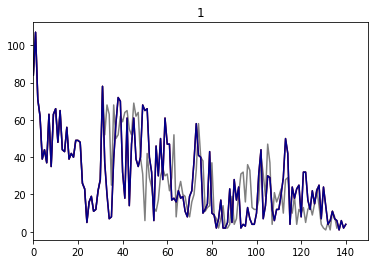

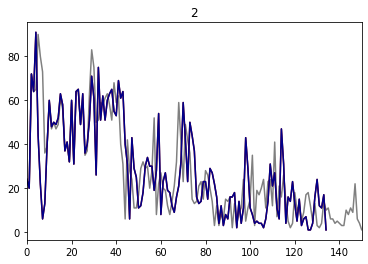

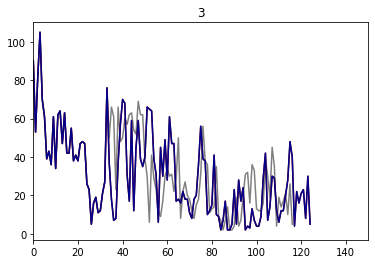

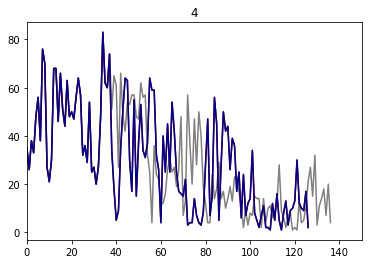

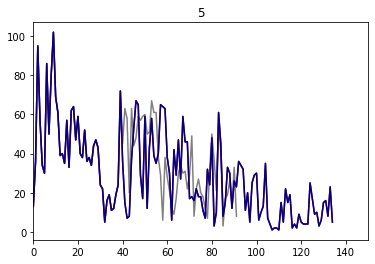

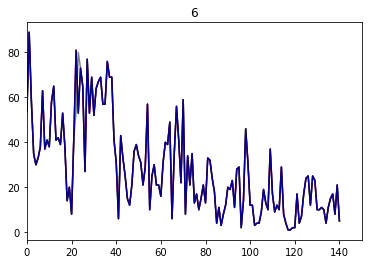

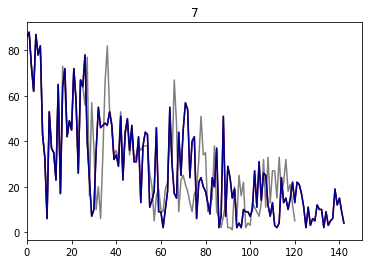

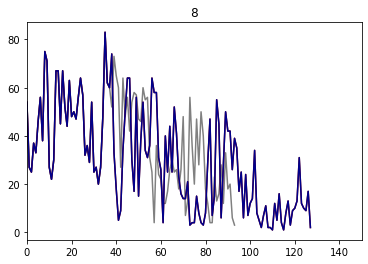

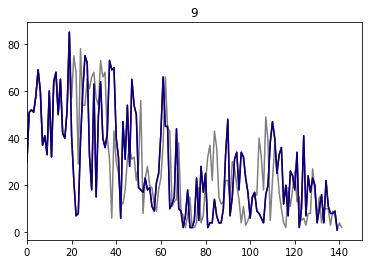

In [101]:
for i in range(10):
    sns.lineplot(x=range(len(df[df['iter']==i].ndens_current0.tolist())), 
                 y=df[df['iter']==i].ndens_current0.tolist(), color='grey')
    sns.lineplot(x=range(len(sdf[sdf['iter']==i].ndens_current0.tolist())), 
                 y=sdf[sdf['iter']==i].ndens_current0.tolist(), color='darkred')
    sns.lineplot(x=range(len(sdf2[sdf2['iter']==i].ndens_current0.tolist())), 
                 y=sdf2[sdf2['iter']==i].ndens_current0.tolist(), color='darkblue')
    plt.xlim(0,150)
    plt.title(i)
    plt.show()

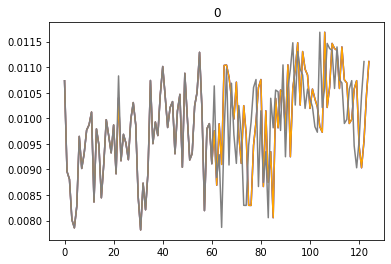

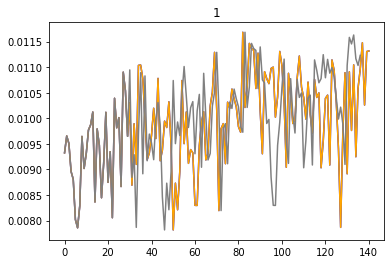

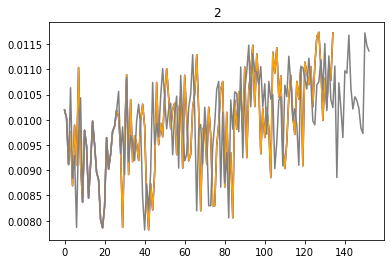

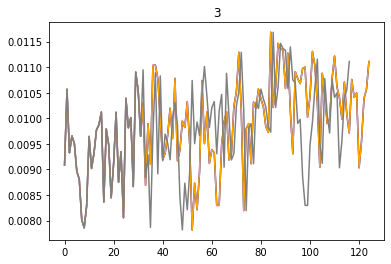

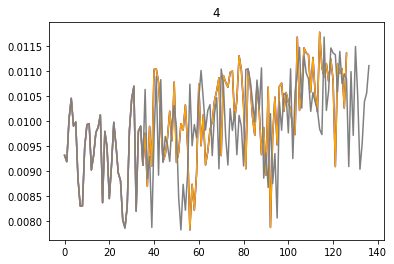

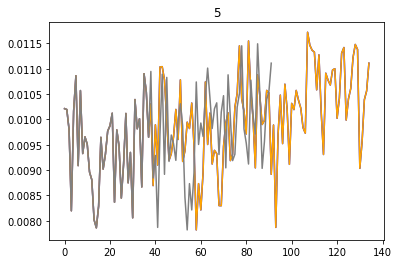

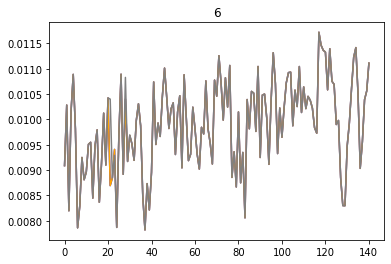

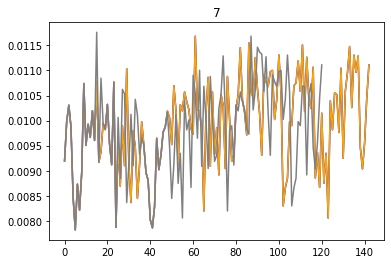

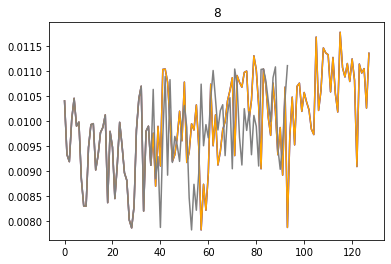

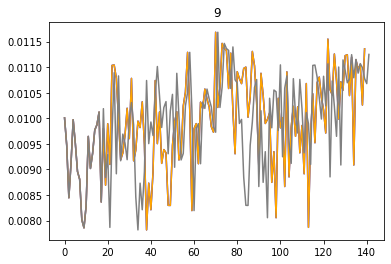

In [72]:
for i in range(10):
    sns.lineplot(x=range(len(sdf[sdf['iter']==i].prob0.tolist())), 
                 y=sdf[sdf['iter']==i].prob0.tolist(), color='darkblue')
    sns.lineplot(x=range(len(sdf2[sdf2['iter']==i].prob0.tolist())), 
                 y=sdf2[sdf2['iter']==i].prob0.tolist(), color='orange')
    sns.lineplot(x=range(len(df[df['iter']==i].prob_listener.tolist())), 
                 y=df[df['iter']==i].prob_listener.tolist(), color='grey')
    plt.title(i)
    plt.show()
#sns.lineplot(x=df[df['iter']==0].prob0.tolist())

## Jumps ~ interaction

Diversity of a pair impacts the search pattern of the pair:
- LMER (1): Effect of diversity on mean jump for the listener
- Diversity prevents the pair from getting stuck in local minima
- -> can we see that reflected in performance? <br>

Performance analysis: does more diversity lead to performance gains from individuals?
- GLMER (1): Effect of diversity on binary predictor for gain
- Confirm that this may have to do with jumps by looking at LMER (2) gain ~ mean jump

Control analyses:
- Is this modulated by individual performance and diversity in performance within a pair?
    - Add individual performance to GLMER (1) and compare models
        - Yes, it does. For high individual performance there is not much to be gained.
    - Add diversity in performance on top of that and compare models. 
        - To do.
